# Table of Contents
- [Data Import](#data-import)
- [Autoencoders](#aes)
    - [Sparse](#sparse) (bottleneck = 1000, sparsity = 1e-05)
    - [Simple (Deep 0) and Deep](#simple-and-deep) (bottleneck = 10)
    - [Convolutional](#convolutional)
    - [Denoising](#denoising)
    - [R^2 Grading](#r2-grading)
- [Readout](#readout)
    - [Fine-tuning](#ft)
        - [Sparse](#ft-sparse)
        - [Simple & Deep](#ft-simple-deep)
        - [Convolutional](#ft-convolutional)
        - [Denoising](#ft-denoising)
        - [Denoising (Original Data)](#ft-denoising-orig)
    - [Frozen Weights](#fw)
        - [Sparse](#fw-sparse)
        - [Simple & Deep](#fw-simple-deep)
        - [Convolutional](#fw-conv)
        - [Denoising](#fw-denois)
        - [Denoising (Original Data)](#fw-denois-orig)
    - [Input](#input)
- [Error Data](#error-data)

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle as pkl

from keras.datasets import mnist
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping

from helpers.AppendedHistory import AppendedHistory
import helpers.mnist as h
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Data Import <a class="anchor" id="data-import"></a>

In [285]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [286]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [287]:
# Normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Reshape to vector
x_train_vec = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_vec = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# Reshape to (28, 28, 1) (for convolution)
x_train_conv = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test_conv = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [288]:
noise_factor = 0.2
x_train_noisy = x_train_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_conv.shape) 
x_test_noisy = x_test_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_conv.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [6]:
d = {}
one_hot = np.zeros(10)
for i in range(10):
    hot = np.copy(one_hot)
    hot[i] = 1
    d[i] = hot

In [7]:
y_train_hot = np.array([d[i] for i in y_train])
y_test_hot = np.array([d[i] for i in y_test])

# Autoencoders

- For MNIST, activations are **bounded** \[0, 255\] (normalised to \[0, 1\]) and **non-binary** in nature.
    - Therefore, we should use **sigmoid activation** with **mean squared error**.

## Sparse <a class="anchor" id="sparse"></a>

In [27]:
autoencoder, encoder, decoder = h.build_autoenc()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_10 (Dense)             (None, 784)               784784    
Total params: 1,569,784
Trainable params: 1,569,784
Non-trainable params: 0
_________________________________________________________________


In [9]:
history_sparsities = AppendedHistory(fname='data/incite/models_log/mnist_new/sparsity_search/batch_size=32/history_sparsities')

In [ ]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
sparsities = [1e-05, 0.0001, 0.1]
for sparsity in sparsities:
    print('sparsity = {}'.format(sparsity))
    autoencoder, encoder, decoder = h.build_autoenc(sparsity=sparsity)
    %time history = autoencoder.fit(x_train_vec, x_train_vec, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test_vec, x_test_vec), \
                              verbose=1, callbacks=[callback])
    history_sparsities.append_hist(sparsity, history)
    autoencoder.save('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/autoencoder_{}'.format(sparsity))
    encoder.save('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/encoder_{}'.format(sparsity))
    decoder.save('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/decoder_{}'.format(sparsity))

In [16]:
history_sparsities.save('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/history_sparsities')

In [2]:
history_sparsities = AppendedHistory(fname='data/incite/models_log/mnist_new/sparsity_search/batch_size=32/history_sparsities')

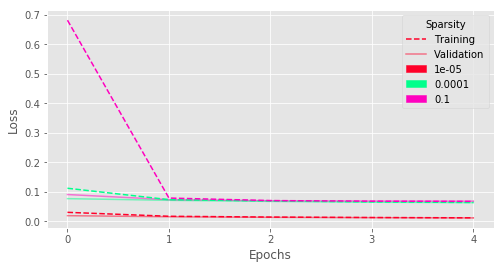

In [3]:
history_sparsities.plot("", "val_loss", False, [0, 100], True)

In [4]:
history_sparsities.get_best()

{'loss': [0.011871408625940482, 0.06393402344584465, 0.06761956118146578],
 'val_loss': [0.011561621654033662, 0.06335854783058166, 0.06838551050424575]}

sparsity = 0.1


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


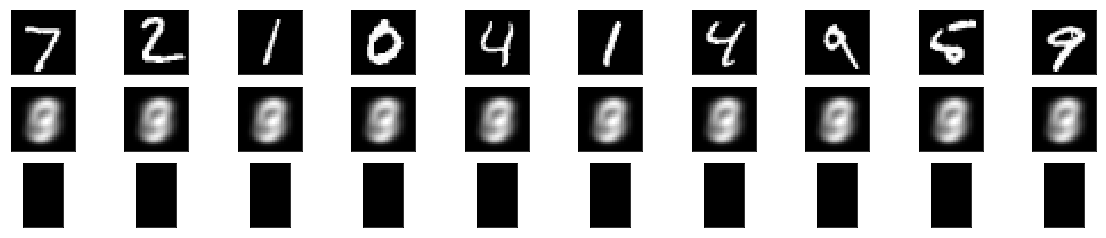

sparsity = 0.0001


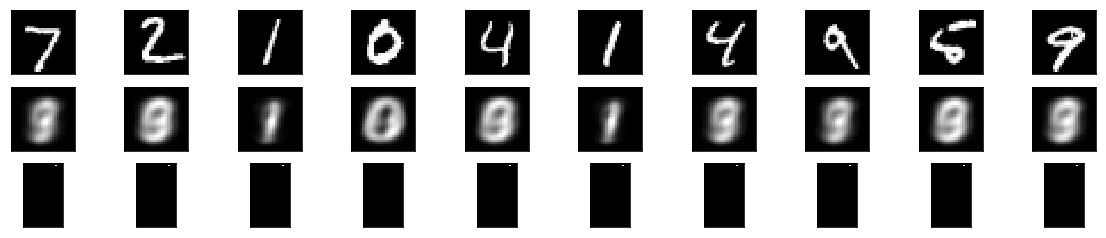

sparsity = 1e-05


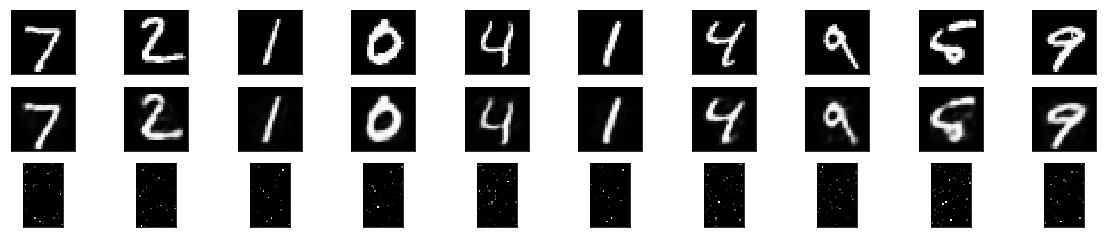

In [21]:
sparsities = [0.1, 0.0001, 0.00001]
for sparsity in sparsities:
    print('sparsity = {}'.format(sparsity))
    encoder = load_model('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/encoder_{}'.format(sparsity))
    autoencoder = load_model('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/autoencoder_{}'.format(sparsity))
    h.display_model(encoder, autoencoder, x_test_vec)

## Simple (Deep 0) & Deep <a class="anchor" id="simple-and-deep"></a>

In [25]:
deep_autoencoder, deep_encoder = h.build_deep_autoenc()
deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


In [112]:
history_deep = AppendedHistory(varname='num_hid', keys=['loss'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
for num_hid in range(5):
    print('num_hid = {}'.format(num_hid))
    deep_autoencoder, deep_encoder = h.build_deep_autoenc(num_hid=num_hid)
    %time history = deep_autoencoder.fit(x_train_vec, x_train_vec, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test_vec, x_test_vec), \
                              verbose=1, callbacks=[callback])
    history_deep.append_hist(num_hid, history)
    deep_autoencoder.save('data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid={}'.format(num_hid))
    deep_encoder.save('data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid={}'.format(num_hid))

In [325]:
history_deep.save('data/incite/models_log/mnist_new/deep_ae/history_deep')

In [5]:
history_deep = AppendedHistory(fname='data/incite/models_log/mnist_new/deep_ae/history_deep')

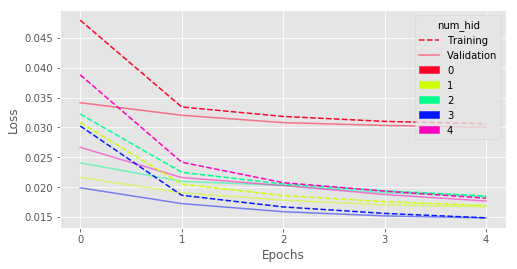

In [6]:
history_deep.plot("", "val_loss", False, [0, 100], True)

In [7]:
history_deep.get_best()

{'loss': [0.03061383162935575,
  0.0169092452570796,
  0.01852404462993145,
  0.014866772596538068,
  0.01815654913733403],
 'val_loss': [0.030020716562867165,
  0.01672002112865448,
  0.01843329179286957,
  0.014854742914438248,
  0.017679521498084067]}

num_hid = 0


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


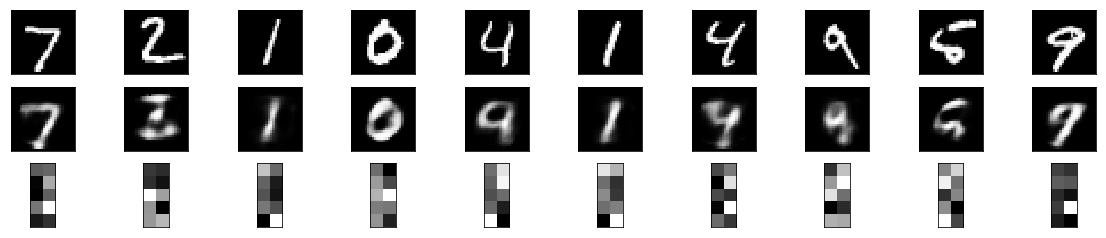

num_hid = 1


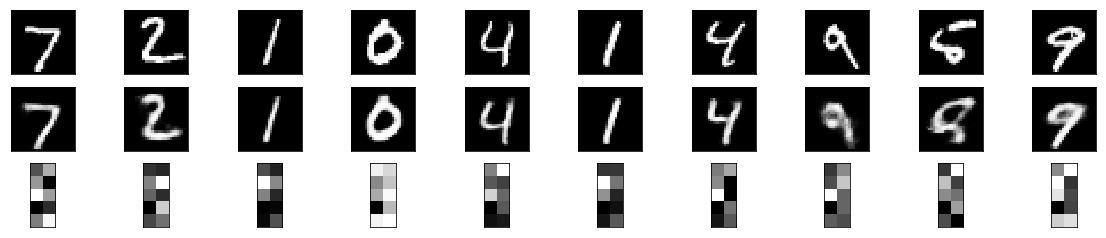

num_hid = 2


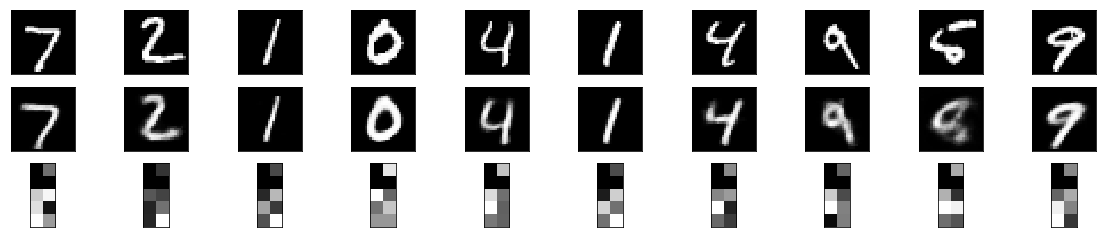

num_hid = 3


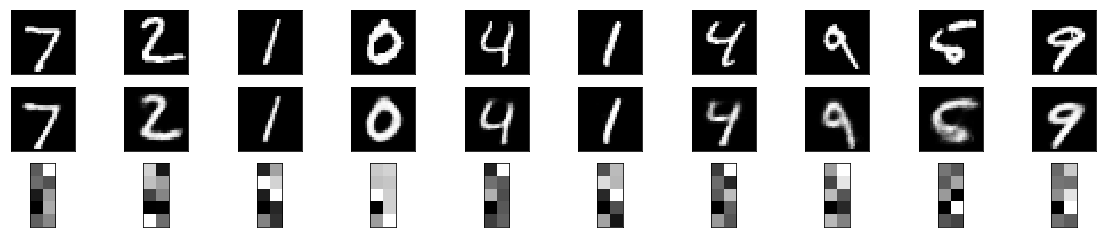

num_hid = 4


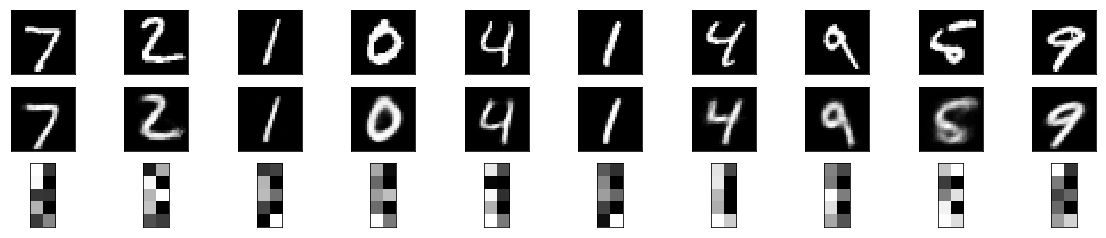

In [24]:
for i in range(5):
    print('num_hid = {}'.format(i))
    encoder = load_model('data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid={}'.format(i))
    autoencoder = load_model('data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid={}'.format(i))
    h.display_model(encoder, autoencoder, x_test_vec, repr_shape=(5, 2))

## Convolutional <a class="anchor" id="convolutional"></a>

In [30]:
conv_autoencoder, conv_encoder = h.build_conv_autoenc()
conv_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [39]:
history_conv = AppendedHistory(varname='Round', keys=['loss'])

In [42]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
conv_autoencoder, conv_encoder = h.build_conv_autoenc()
%time history = conv_autoencoder.fit(x_train_conv, x_train_conv, \
                                     epochs=5, \
                                     batch_size=32, \
                                     shuffle=True, \
                                     validation_data=(x_test_conv, x_test_conv), \
                                     verbose=1, callbacks=[callback])
history_conv.append_hist(0, history)
conv_autoencoder.save('data/incite/models_log/mnist_new/conv_ae/conv_autoencoder')
conv_encoder.save('data/incite/models_log/mnist_new/conv_ae/conv_encoder')

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 111s 2ms/step - loss: 0.1622 - val_loss: 0.1260
Epoch 2/5
60000/60000 [==============================] - 120s 2ms/step - loss: 0.1255 - val_loss: 0.1227
Epoch 3/5
60000/60000 [==============================] - 116s 2ms/step - loss: 0.1181 - val_loss: 0.1161
Epoch 4/5
60000/60000 [==============================] - 106s 2ms/step - loss: 0.1135 - val_loss: 0.1106
Epoch 5/5
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1113 - val_loss: 0.1074
CPU times: user 13min 42s, sys: 6min 49s, total: 20min 31s
Wall time: 9min 15s


In [43]:
history_conv.save('data/incite/models_log/mnist_new/conv_ae/history_conv')

In [8]:
history_conv = AppendedHistory(fname='data/incite/models_log/mnist_new/conv_ae/history_conv')

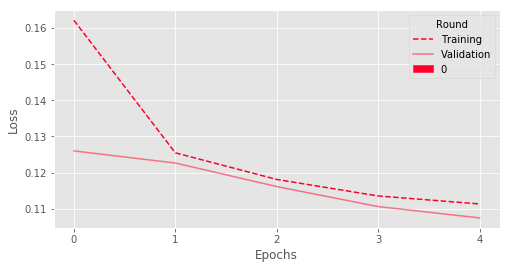

In [9]:
history_conv.plot("", "val_loss", False, [0, 100], True)

In [10]:
history_conv.get_best()

{'loss': [0.11131585603555044], 'val_loss': [0.10744727900028228]}

In [49]:
encoder = load_model('data/incite/models_log/mnist_new/conv_ae/conv_encoder'.format(i))
autoencoder = load_model('data/incite/models_log/mnist_new/conv_ae/conv_autoencoder'.format(i))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


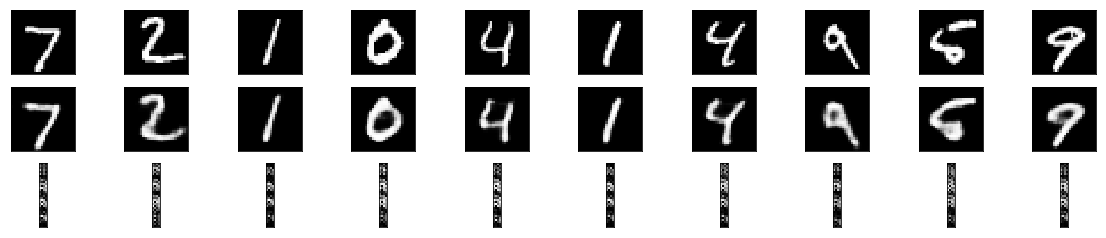

In [51]:
h.display_model(encoder, autoencoder, x_test_conv, repr_shape=(32, 4))

## Denoising <a class="anchor" id="denoising"></a>

In [116]:
denois_autoencoder, denois_encoder = h.build_denois_autoenc()
denois_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_24 (UpSampling (None, 14, 14, 32)        0         
__________

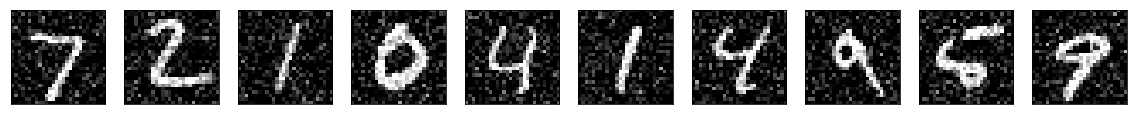

In [206]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [120]:
history_denois = AppendedHistory(varname='noise_factor', keys=['loss'])

In [121]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
denois_autoencoder, denois_encoder = h.build_denois_autoenc()
%time history = denois_autoencoder.fit(x_train_noisy, x_train_conv, \
                                       epochs=5, \
                                       batch_size=32, \
                                       shuffle=True, \
                                       validation_data=(x_test_noisy, x_test_conv), \
                                       verbose=1, callbacks=[callback])
history_denois.append_hist(0.2, history)
denois_autoencoder.save('data/incite/models_log/mnist_new/denois_ae/denois_autoencoder')
denois_encoder.save('data/incite/models_log/mnist_new/denois_ae/denois_encoder')

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 207s 3ms/step - loss: 0.1016 - val_loss: 0.0821
Epoch 2/5
60000/60000 [==============================] - 187s 3ms/step - loss: 0.0793 - val_loss: 0.0763
Epoch 3/5
60000/60000 [==============================] - 212s 4ms/step - loss: 0.0766 - val_loss: 0.0756
Epoch 4/5
60000/60000 [==============================] - 212s 4ms/step - loss: 0.0754 - val_loss: 0.0750
Epoch 5/5
60000/60000 [==============================] - 202s 3ms/step - loss: 0.0746 - val_loss: 0.0731
CPU times: user 28min 54s, sys: 15min 48s, total: 44min 42s
Wall time: 17min 1s


In [122]:
history_denois.save('data/incite/models_log/mnist_new/denois_ae/history_denois')

In [11]:
history_denois = AppendedHistory(fname='data/incite/models_log/mnist_new/denois_ae/history_denois')

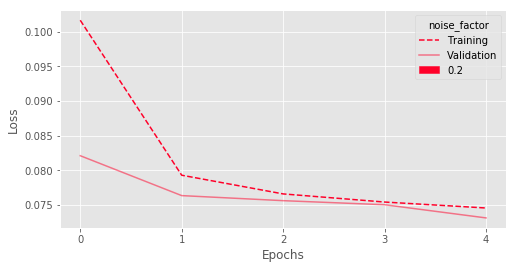

In [12]:
history_denois.plot("", "val_loss", False, [0, 100], True)

In [13]:
history_denois.get_best()

{'loss': [0.07455243165493011], 'val_loss': [0.07312159585952759]}

In [125]:
encoder = load_model('data/incite/models_log/mnist_new/denois_ae/denois_encoder'.format(i))
autoencoder = load_model('data/incite/models_log/mnist_new/denois_ae/denois_autoencoder'.format(i))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


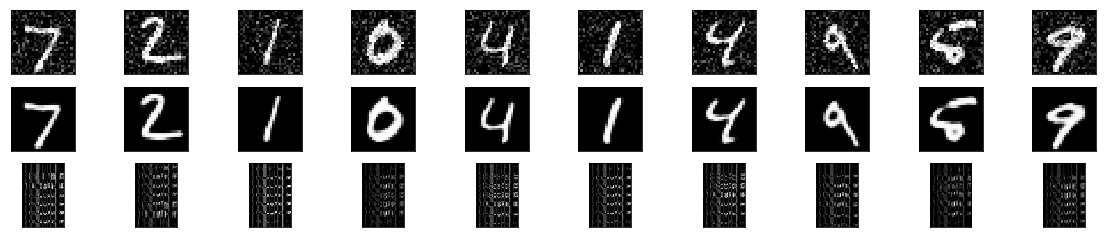

In [127]:
h.display_model(encoder, autoencoder, x_test_noisy, repr_shape=(49, 32))

## R^2 Grading <a class="anchor" id="r2-grading"></a>

In [289]:
# !!! PATHS
keys_vec = ['simple', 'sparse', 'deep_1', 'deep_2', 'deep_3', 'deep_4']
keys_conv = ['conv', 'denois']

autoencoders = {'simple': 'data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid=0', \
            'sparse': 'data/incite/models_log/mnist_new/sparsity_search/batch_size=32/autoencoder_1e-05', \
            'deep_1': 'data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid=1', \
            'deep_2': 'data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid=2', \
            'deep_3': 'data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid=3', \
            'deep_4': 'data/incite/models_log/mnist_new/deep_ae/deep_autoencoder_num_hid=4', \
            'conv': 'data/incite/models_log/mnist_new/conv_ae/conv_autoencoder', \
            'denois': 'data/incite/models_log/mnist_new/denois_ae/denois_autoencoder'}

In [317]:
plt_titles = {'simple': 'MNIST 784-10- AE', \
              'sparse': 'MNIST 784-1000- Sparse AE', \
              'deep_1': 'MNIST 784-397-10- AE', \
              'deep_2': 'MNIST 784-526-268-10- AE', \
              'deep_3': 'MNIST 784-590-397-203-10- AE', \
              'deep_4': 'MNIST 784-629-474-319-164-10- AE', \
              'conv': 'MNIST Conv AE', \
              'denois': 'MNIST Denois AE'}

fig_name = 'data/incite/models_log/mnist_new/pics/r2/{}.pdf'

In [ ]:
for key in keys_vec:
    print(key)
    autoencoder = load_model(autoencoders[key])
    h.get_r2(autoencoder, x_test_vec, plt_titles[key], figname=fig_name.format(key))

In [ ]:
autoencoder = load_model(autoencoders['conv'])
h.get_r2(autoencoder, x_test_conv, plt_titles['conv'], figname=fig_name.format('conv'))
autoencoder = load_model(autoencoders['denois'])
h.get_r2(autoencoder, x_test_conv, plt_titles['denois'], x_train=x_test_noisy, figname=fig_name.format('denois'))

# Readout <a class="anchor" id="readout"></a>
## Fine-tuning <a class="anchor" id="ft"></a>
### Sparse <a class="anchor" id="ft-sparse"></a>

In [208]:
history_readout = AppendedHistory(varname="num_hid")

In [ ]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
num_hids = [0]
for num_hid in num_hids:
    print('num_hid = {}'.format(num_hid))
    encoder = load_model('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/encoder_1e-05')
    readout = h.build_readout(encoder)
    %time history = readout.fit(x_train_vec, y_train_hot, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test_vec, y_test_hot), \
                              verbose=1, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_readout.append_hist(num_hid, history)
    readout.save('data/incite/models_log/mnist_new/readout_ae_1e-05/finetuning/readout_num_hid={}'.format(num_hid))

In [210]:
history_readout.save('data/incite/models_log/mnist_new/readout_ae_1e-05/finetuning/history_readout')

In [31]:
history_readout = AppendedHistory(fname='data/incite/models_log/mnist_new/readout_ae_1e-05/finetuning/history_readout')

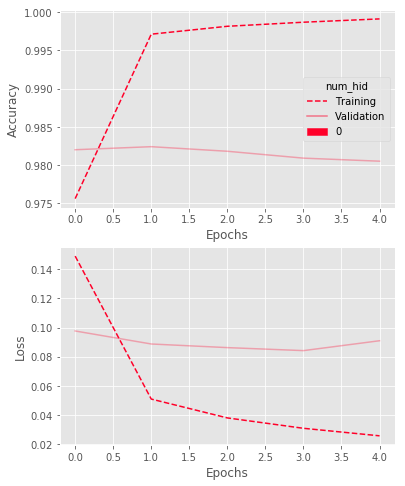

In [32]:
history_readout.plot_acc_loss("", "", "val_")

### Simple & Deep <a class="anchor" id="ft-simple-deep"></a>

In [301]:
history_readout_deep = AppendedHistory(varname="num_hid")

In [ ]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
for i in range(5):
    print('ae num_hid = {}'.format(i))
    encoder = load_model('data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid={}'.format(i))
    readout = h.build_readout(encoder)
    %time history = readout.fit(x_train_vec, y_train_hot, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test_vec, y_test_hot), \
                              verbose=1, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_readout_deep.append_hist(i, history)
    readout.save('data/incite/models_log/mnist_new/readout_deep_ae/readout_num_hid={}'.format(i))

In [329]:
history_readout_deep.save('data/incite/models_log/mnist_new/readout_deep_ae/finetuning/history_readout_deep')

In [29]:
history_readout_deep = AppendedHistory(fname='data/incite/models_log/mnist_new/readout_deep_ae/finetuning/history_readout_deep')

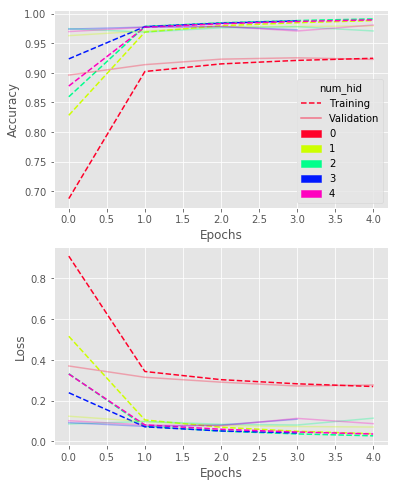

In [30]:
history_readout_deep.plot_acc_loss("", "", "val_")

### Convolutional <a class="anchor" id="ft-convolutional"></a>

In [66]:
history_readout_conv = AppendedHistory(varname="Round")

In [67]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
encoder = load_model('data/incite/models_log/mnist_new/conv_ae/conv_encoder'.format(i))
readout = h.build_readout(encoder, conv=True)
%time history = readout.fit(x_train_conv, y_train_hot, \
                            epochs=5, \
                            batch_size=32, \
                            shuffle=True, \
                            validation_data=(x_test_conv, y_test_hot), \
                            verbose=1, callbacks=[callback])
history.history['acc'] = history.history.pop('categorical_accuracy')
history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
history_readout_conv.append_hist(i, history)
readout.save('data/incite/models_log/mnist_new/readout_conv_ae/finetuning/readout'.format(i))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 42s 693us/step - loss: 1.0060 - categorical_accuracy: 0.1630 - val_loss: 0.1409 - val_categorical_accuracy: 0.9582
Epoch 2/5
60000/60000 [==============================] - 41s 680us/step - loss: 0.1140 - categorical_accuracy: 0.9639 - val_loss: 0.0666 - val_categorical_accuracy: 0.9796
Epoch 3/5
60000/60000 [==============================] - 39s 643us/step - loss: 0.0799 - categorical_accuracy: 0.9746 - val_loss: 0.0577 - val_categorical_accuracy: 0.9815
Epoch 4/5
60000/60000 [==============================] - 38s 634us/step - loss: 0.0660 - categorical_accuracy: 0.9796 - val_loss: 0.0517 - val_categorical_accuracy: 0.9825
Epoch 5/5
60000/60000 [==============================] - 38s 635us/step - loss: 0.0594 - categorical_accuracy: 0.9814 - val_loss: 0.0452 - val_categorical_accuracy: 0.9843
CPU times: user 5min 28s, sys: 1min 56s, total: 7min 24s
Wall time: 3min 17s


In [69]:
history_readout_conv.save('data/incite/models_log/mnist_new/readout_conv_ae/finetuning/history_readout_conv')

In [70]:
history_readout_conv = AppendedHistory(
    fname='data/incite/models_log/mnist_new/readout_conv_ae/finetuning/history_readout_conv')

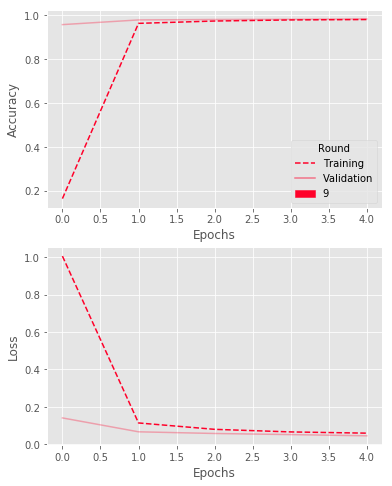

In [71]:
history_readout_conv.plot_acc_loss("", "", "val_")

### Denoising <a class="anchor" id="ft-denoising"></a>

In [128]:
history_readout_denois = AppendedHistory(varname="Round")

In [138]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
encoder = load_model('data/incite/models_log/mnist_new/denois_ae/denois_encoder')
readout = h.build_readout(encoder, conv=True)
%time history = readout.fit(x_train_noisy, y_train_hot, \
                            epochs=5, \
                            batch_size=32, \
                            shuffle=True, \
                            validation_data=(x_test_noisy, y_test_hot), \
                            verbose=1, callbacks=[callback])
history.history['acc'] = history.history.pop('categorical_accuracy')
history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
history_readout_denois.append_hist(0, history)
readout.save('data/incite/models_log/mnist_new/readout_denois_ae/finetuning/readout'.format(i))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 71s 1ms/step - loss: 0.1926 - categorical_accuracy: 0.9405 - val_loss: 0.0795 - val_categorical_accuracy: 0.9730
Epoch 2/5
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0701 - categorical_accuracy: 0.9789 - val_loss: 0.0541 - val_categorical_accuracy: 0.9819
Epoch 3/5
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0522 - categorical_accuracy: 0.9838 - val_loss: 0.0532 - val_categorical_accuracy: 0.9836
Epoch 4/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0411 - categorical_accuracy: 0.9872 - val_loss: 0.0489 - val_categorical_accuracy: 0.9847
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0332 - categorical_accuracy: 0.9894 - val_loss: 0.0578 - val_categorical_accuracy: 0.9820
CPU times: user 11min 21s, sys: 1min 55s, total: 13min 16s
Wall time: 5min 39s


In [144]:
history_readout_denois.save('data/incite/models_log/mnist_new/readout_denois_ae/finetuning/history_readout_denois')

In [145]:
history_readout_denois = AppendedHistory(
    fname='data/incite/models_log/mnist_new/readout_denois_ae/finetuning/history_readout_denois')

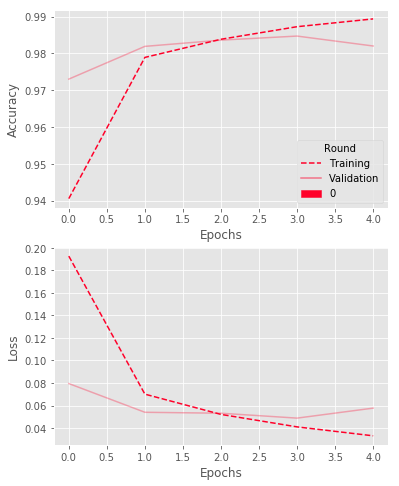

In [146]:
history_readout_denois.plot_acc_loss("", "", "val_")

### Denoising (Original Data) <a class="anchor" id="ft-denoising-orig"></a>

In [180]:
history_readout_denois_o = AppendedHistory(varname="Round")

In [182]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
encoder = load_model('data/incite/models_log/mnist_new/denois_ae/denois_encoder')
readout = h.build_readout(encoder, conv=True)
%time history = readout.fit(x_train_conv, y_train_hot, \
                            epochs=5, \
                            batch_size=32, \
                            shuffle=True, \
                            validation_data=(x_test_conv, y_test_hot), \
                            verbose=1, callbacks=[callback])
history.history['acc'] = history.history.pop('categorical_accuracy')
history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
history_readout_denois_o.append_hist(0, history)
readout.save('data/incite/models_log/mnist_new/readout_denois_ae/finetuning/readout_orig'.format(i))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1660 - categorical_accuracy: 0.9489 - val_loss: 0.0685 - val_categorical_accuracy: 0.9781
Epoch 2/5
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0580 - categorical_accuracy: 0.9828 - val_loss: 0.0452 - val_categorical_accuracy: 0.9860
Epoch 3/5
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0439 - categorical_accuracy: 0.9863 - val_loss: 0.0425 - val_categorical_accuracy: 0.9870
Epoch 4/5
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0341 - categorical_accuracy: 0.9890 - val_loss: 0.0350 - val_categorical_accuracy: 0.9885
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0278 - categorical_accuracy: 0.9907 - val_loss: 0.0353 - val_categorical_accuracy: 0.9894
CPU times: user 10min 38s, sys: 1min 57s, total: 12min 36s
Wall time: 5min 16s


In [183]:
history_readout_denois_o.save('data/incite/models_log/mnist_new/readout_denois_ae/finetuning/history_readout_denois_o')

In [184]:
history_readout_denois_o = AppendedHistory(
    fname='data/incite/models_log/mnist_new/readout_denois_ae/finetuning/history_readout_denois_o')

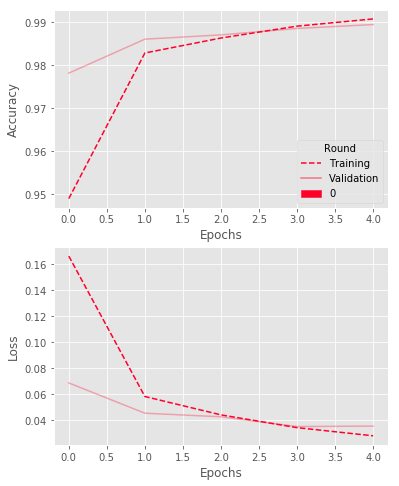

In [185]:
history_readout_denois_o.plot_acc_loss("", "", "val_")

## Frozen Weights <a class="anchor" id="fw"></a>
### Sparse <a class="anchor" id="fw-sparse"></a>

In [439]:
encoder = load_model('data/incite/models_log/mnist_new/sparsity_search/batch_size=32/encoder_1e-05')
encoded_train = encoder.predict(x_train_vec)
encoded_test = encoder.predict(x_test_vec)

In [440]:
history_readout_unp = AppendedHistory(varname="num_hid")

In [ ]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
num_hids = [0]
for num_hid in num_hids:
    print('num_hid = {}'.format(num_hid))
    readout = h.build_readout(input_shape=(1000,))
    %time history = readout.fit(encoded_train, y_train_hot, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(encoded_test, y_test_hot), \
                              verbose=1, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_readout_unp.append_hist(num_hid, history)
    readout.save('data/incite/models_log/mnist_new/readout_ae_1e-05/frozenweights/readout_num_hid={}'.format(num_hid))

In [443]:
history_readout_unp.save('data/incite/models_log/mnist_new/readout_ae_1e-05/frozenweights/history_readout')

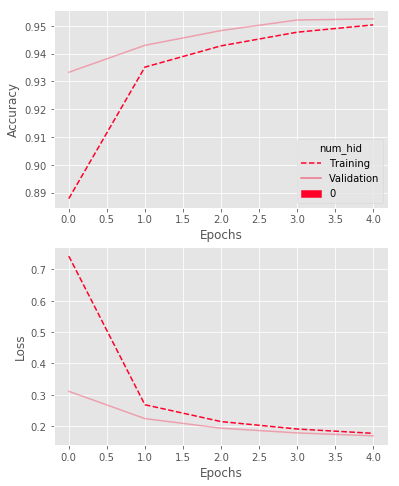

In [444]:
history_readout_unp.plot_acc_loss("", "", "val_")

### Simple & Deep <a class="anchor" id="fw-simple-deep"></a>

In [33]:
history_readout_unp_deep = AppendedHistory(varname="num_hid")

In [37]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
for num_hid in range(5):
    print('ae num_hid = {}'.format(num_hid))
    readout = h.build_readout(input_shape=(10,))
    encoder = load_model('data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid={}'.format(num_hid))
    encoded_train = encoder.predict(x_train_vec)
    encoded_test = encoder.predict(x_test_vec)
    %time history = readout.fit(encoded_train, y_train_hot, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(encoded_test, y_test_hot), \
                              verbose=1, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_readout_unp_deep.append_hist(num_hid, history)
    readout.save('data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/readout_num_hid={}'.format(num_hid))

ae num_hid = 0


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 22s 362us/step - loss: 2.0268 - categorical_accuracy: 0.0627 - val_loss: 1.4971 - val_categorical_accuracy: 0.0935
Epoch 2/5
60000/60000 [==============================] - 11s 176us/step - loss: 1.3657 - categorical_accuracy: 0.0975 - val_loss: 1.2986 - val_categorical_accuracy: 0.0975
Epoch 3/5
60000/60000 [==============================] - 12s 199us/step - loss: 1.2921 - categorical_accuracy: 0.0992 - val_loss: 1.2733 - val_categorical_accuracy: 0.0988
Epoch 4/5
60000/60000 [==============================] - 12s 195us/step - loss: 1.1840 - categorical_accuracy: 0.2443 - val_loss: 0.7119 - val_categorical_accuracy: 0.7745
Epoch 5/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.6457 - categorical_accuracy: 0.7957 - val_loss: 0.5874 - val_categorical_accuracy: 0.8109
CPU times: user 37.6 s, sys: 2.16 s, total: 39.7 s
Wall time: 1min 9s
ae num_hid = 1


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 262us/step - loss: 2.5281 - categorical_accuracy: 0.0626 - val_loss: 1.6836 - val_categorical_accuracy: 0.0873
Epoch 2/5
60000/60000 [==============================] - 14s 229us/step - loss: 1.4410 - categorical_accuracy: 0.1561 - val_loss: 0.9815 - val_categorical_accuracy: 0.6862
Epoch 3/5
60000/60000 [==============================] - 13s 209us/step - loss: 0.4598 - categorical_accuracy: 0.8576 - val_loss: 0.3737 - val_categorical_accuracy: 0.8828
Epoch 4/5
60000/60000 [==============================] - 12s 203us/step - loss: 0.3833 - categorical_accuracy: 0.8816 - val_loss: 0.3612 - val_categorical_accuracy: 0.8867
Epoch 5/5
60000/60000 [==============================] - 13s 214us/step - loss: 0.3786 - categorical_accuracy: 0.8830 - val_loss: 0.3625 - val_categorical_accuracy: 0.8885
CPU times: user 37.6 s, sys: 2.12 s, total: 39.7 s
Wall time: 1min 8s
ae num_hid = 2


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 281us/step - loss: 1.8979 - categorical_accuracy: 0.6316 - val_loss: 0.3821 - val_categorical_accuracy: 0.8919ss: 1.9220 - categorical_accuracy: 
Epoch 2/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.3538 - categorical_accuracy: 0.9000 - val_loss: 0.3308 - val_categorical_accuracy: 0.9048
Epoch 3/5
60000/60000 [==============================] - 13s 216us/step - loss: 0.3282 - categorical_accuracy: 0.9059 - val_loss: 0.3249 - val_categorical_accuracy: 0.9040
Epoch 4/5
60000/60000 [==============================] - 12s 203us/step - loss: 0.3202 - categorical_accuracy: 0.9076 - val_loss: 0.3130 - val_categorical_accuracy: 0.9091
Epoch 5/5
60000/60000 [==============================] - 12s 208us/step - loss: 0.3162 - categorical_accuracy: 0.9093 - val_loss: 0.3094 - val_categorical_accuracy: 0.9098
CPU times: user 38.2 s, sys: 2.13 s, total: 40.4 s
Wall

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 274us/step - loss: 1.4448 - categorical_accuracy: 0.3651 - val_loss: 0.4346 - val_categorical_accuracy: 0.8687
Epoch 2/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.3638 - categorical_accuracy: 0.8896 - val_loss: 0.3196 - val_categorical_accuracy: 0.9042
Epoch 3/5
60000/60000 [==============================] - 12s 205us/step - loss: 0.3239 - categorical_accuracy: 0.9010 - val_loss: 0.3064 - val_categorical_accuracy: 0.9065
Epoch 4/5
60000/60000 [==============================] - 13s 209us/step - loss: 0.3153 - categorical_accuracy: 0.9029 - val_loss: 0.3007 - val_categorical_accuracy: 0.9091
Epoch 5/5
60000/60000 [==============================] - 14s 225us/step - loss: 0.3113 - categorical_accuracy: 0.9044 - val_loss: 0.3004 - val_categorical_accuracy: 0.9083
CPU times: user 38.1 s, sys: 2.19 s, total: 40.3 s
Wall time: 1min 8s
ae num_hid = 4


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 18s 305us/step - loss: 1.3590 - categorical_accuracy: 0.3980 - val_loss: 0.4143 - val_categorical_accuracy: 0.8819
Epoch 2/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.3621 - categorical_accuracy: 0.8952 - val_loss: 0.3324 - val_categorical_accuracy: 0.9065
Epoch 3/5
60000/60000 [==============================] - 13s 210us/step - loss: 0.3271 - categorical_accuracy: 0.9056 - val_loss: 0.3130 - val_categorical_accuracy: 0.9123
Epoch 4/5
60000/60000 [==============================] - 13s 211us/step - loss: 0.3169 - categorical_accuracy: 0.9075 - val_loss: 0.3105 - val_categorical_accuracy: 0.9099
Epoch 5/5
60000/60000 [==============================] - 14s 239us/step - loss: 0.3117 - categorical_accuracy: 0.9083 - val_loss: 0.3097 - val_categorical_accuracy: 0.9116
CPU times: user 40.3 s, sys: 2.32 s, total: 42.6 s
Wall time: 1min 13s


In [46]:
history_readout_unp_deep.save('data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/history_readout')

In [47]:
history_readout_unp_deep = AppendedHistory(fname='data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/history_readout')

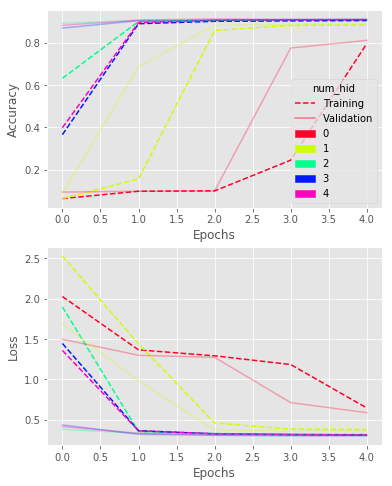

In [48]:
history_readout_unp_deep.plot_acc_loss("", "", "val_")

### Convolutional <a class="anchor" id="fw-conv"></a>

In [81]:
encoder = load_model('data/incite/models_log/mnist_new/conv_ae/conv_encoder')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [83]:
x_train_pred = encoder.predict(x_train_conv)
x_test_pred = encoder.predict(x_test_conv)

In [84]:
history_readout_conv_unp = AppendedHistory(varname="Round")

In [85]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
readout = h.build_readout(input_shape=(4, 4, 8,), conv=True)
%time history = readout.fit(x_train_pred, y_train_hot, \
                            epochs=5, \
                            batch_size=32, \
                            shuffle=True, \
                            validation_data=(x_test_pred, y_test_hot), \
                            verbose=1, callbacks=[callback])
history.history['acc'] = history.history.pop('categorical_accuracy')
history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
history_readout_conv_unp.append_hist(i, history)
readout.save('data/incite/models_log/mnist_new/readout_conv_ae/frozenweights/readout'.format(i))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 68us/step - loss: 1.3927 - categorical_accuracy: 0.1835 - val_loss: 0.3405 - val_categorical_accuracy: 0.8936
Epoch 2/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.2807 - categorical_accuracy: 0.9095 - val_loss: 0.2279 - val_categorical_accuracy: 0.9269
Epoch 3/5
60000/60000 [==============================] - 3s 52us/step - loss: 0.2136 - categorical_accuracy: 0.9306 - val_loss: 0.1791 - val_categorical_accuracy: 0.9429
Epoch 4/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.1904 - categorical_accuracy: 0.9392 - val_loss: 0.1634 - val_categorical_accuracy: 0.9488
Epoch 5/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.1747 - categorical_accuracy: 0.9444 - val_loss: 0.1528 - val_categorical_accuracy: 0.9526
CPU times: user 22.8 s, sys: 3.34 s, total: 26.1 s
Wall time: 17.1 s


In [87]:
history_readout_conv_unp.save('data/incite/models_log/mnist_new/readout_conv_ae/frozenweights/history_readout')

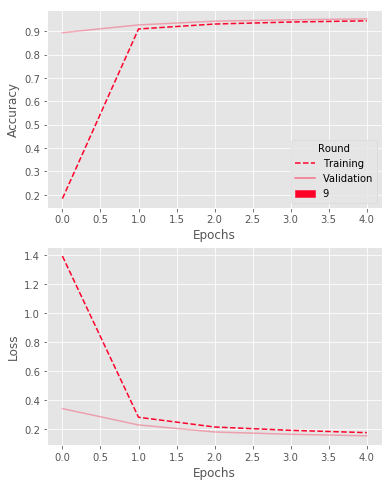

In [88]:
history_readout_conv_unp.plot_acc_loss("", "", "val_")

### Denoising <a class="anchor" id="fw-denois"></a>

In [147]:
history_readout_denois_unp = AppendedHistory(varname="Round")

In [149]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
encoder = load_model('data/incite/models_log/mnist_new/denois_ae/denois_encoder')
x_train_pred = encoder.predict(x_train_noisy)
x_test_pred = encoder.predict(x_test_noisy)
readout = h.build_readout(conv=True, input_shape=(7, 7, 32,))
%time history = readout.fit(x_train_pred, y_train_hot, \
                            epochs=5, \
                            batch_size=32, \
                            shuffle=True, \
                            validation_data=(x_test_pred, y_test_hot), \
                            verbose=1, callbacks=[callback])
history.history['acc'] = history.history.pop('categorical_accuracy')
history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
history_readout_denois_unp.append_hist(0, history)
readout.save('data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/readout'.format(i))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 164us/step - loss: 0.3182 - categorical_accuracy: 0.9110 - val_loss: 0.2058 - val_categorical_accuracy: 0.9381
Epoch 2/5
60000/60000 [==============================] - 7s 118us/step - loss: 0.1645 - categorical_accuracy: 0.9512 - val_loss: 0.1421 - val_categorical_accuracy: 0.9581
Epoch 3/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.1325 - categorical_accuracy: 0.9604 - val_loss: 0.1280 - val_categorical_accuracy: 0.9626
Epoch 4/5
60000/60000 [==============================] - 6s 99us/step - loss: 0.1159 - categorical_accuracy: 0.9663 - val_loss: 0.1144 - val_categorical_accuracy: 0.9653
Epoch 5/5
60000/60000 [==============================] - 7s 111us/step - loss: 0.1025 - categorical_accuracy: 0.9698 - val_loss: 0.1034 - val_categorical_accuracy: 0.9702
CPU times: user 41.2 s, sys: 4.99 s, total: 46.2 s
Wall time: 36 s


In [150]:
history_readout_denois_unp.save('data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/history_readout_denois')

In [151]:
history_readout_denois_unp = AppendedHistory(
    fname='data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/history_readout_denois')

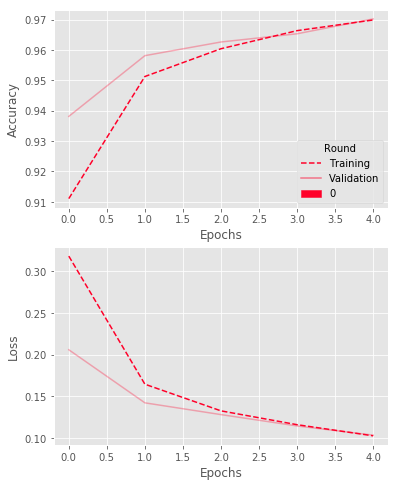

In [152]:
history_readout_denois_unp.plot_acc_loss("", "", "val_")

### Denoising (Original Data) <a class="anchor" id="fw-denois-orig"></a>

In [169]:
encoder = load_model('data/incite/models_log/mnist_new/denois_ae/denois_encoder')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [173]:
x_train_pred = encoder.predict(x_train_conv)
x_test_pred = encoder.predict(x_test_conv)

In [174]:
history_readout_denois_unp_o = AppendedHistory(varname="Round")

In [175]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
readout = h.build_readout(conv=True, input_shape=(7, 7, 32,))
%time history = readout.fit(x_train_pred, y_train_hot, \
                            epochs=5, \
                            batch_size=32, \
                            shuffle=True, \
                            validation_data=(x_test_pred, y_test_hot), \
                            verbose=1, callbacks=[callback])
history.history['acc'] = history.history.pop('categorical_accuracy')
history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
history_readout_denois_unp_o.append_hist(0, history)
readout.save('data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/readout_orig'.format(i))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.2838 - categorical_accuracy: 0.9224 - val_loss: 0.1601 - val_categorical_accuracy: 0.9542
Epoch 2/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.1414 - categorical_accuracy: 0.9587 - val_loss: 0.1108 - val_categorical_accuracy: 0.9685
Epoch 3/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.1110 - categorical_accuracy: 0.9681 - val_loss: 0.0965 - val_categorical_accuracy: 0.9715
Epoch 4/5
60000/60000 [==============================] - 6s 106us/step - loss: 0.0959 - categorical_accuracy: 0.9728 - val_loss: 0.0921 - val_categorical_accuracy: 0.9727
Epoch 5/5
60000/60000 [==============================] - 6s 108us/step - loss: 0.0854 - categorical_accuracy: 0.9754 - val_loss: 0.0851 - val_categorical_accuracy: 0.9737
CPU times: user 40.7 s, sys: 3.89 s, total: 44.6 s
Wall time: 33.3 s


In [176]:
history_readout_denois_unp_o.save('data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/history_readout_denois_o')

In [177]:
history_readout_denois_unp_o = AppendedHistory(
    fname='data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/history_readout_denois_o')

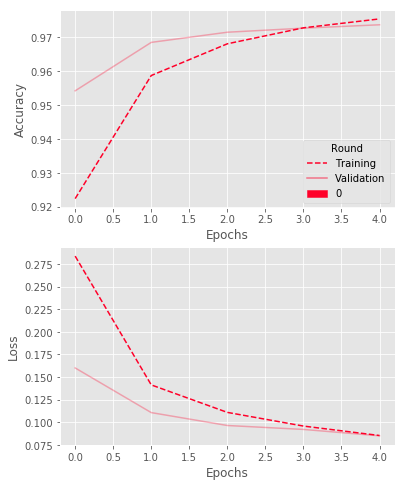

In [179]:
history_readout_denois_unp_o.plot_acc_loss("", "", "val_")

## Input <a class="anchor" id="input"></a>

In [226]:
history_readout_in = AppendedHistory(varname="num_hid")

In [227]:
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
num_hids = [0]
for num_hid in num_hids:
    print('num_hid = {}'.format(num_hid))
    readout = h.build_readout()
    %time history = readout.fit(x_train_vec, y_train_hot, \
                              epochs=5, \
                              batch_size=32, \
                              shuffle=True, \
                              validation_data=(x_test_vec, y_test_hot), \
                              verbose=1, callbacks=[callback])
    history.history['acc'] = history.history.pop('categorical_accuracy')
    history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
    history_readout_in.append_hist(num_hid, history)
    readout.save('data/incite/models_log/mnist_new/readout_in/readout_num_hid={}'.format(num_hid))

num_hid = 0
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 151us/step - loss: 0.4894 - categorical_accuracy: 0.8763 - val_loss: 0.3096 - val_categorical_accuracy: 0.9135
Epoch 2/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.3050 - categorical_accuracy: 0.9158 - val_loss: 0.2820 - val_categorical_accuracy: 0.9211
Epoch 3/5
60000/60000 [==============================] - 6s 104us/step - loss: 0.2843 - categorical_accuracy: 0.9210 - val_loss: 0.2724 - val_categorical_accuracy: 0.9245
Epoch 4/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.2737 - categorical_accuracy: 0.9237 - val_loss: 0.2681 - val_categorical_accuracy: 0.9253
Epoch 5/5
60000/60000 [==============================] - 6s 107us/step - loss: 0.2666 - categorical_accuracy: 0.9260 - val_loss: 0.2650 - val_categorical_accuracy: 0.9262
CPU times: user 41.7 s, sys: 3.84 s, total: 45.5 s
Wall time: 34.9 s


In [229]:
history_readout_in.save('data/incite/models_log/mnist_new/readout_in/history_readout_in')

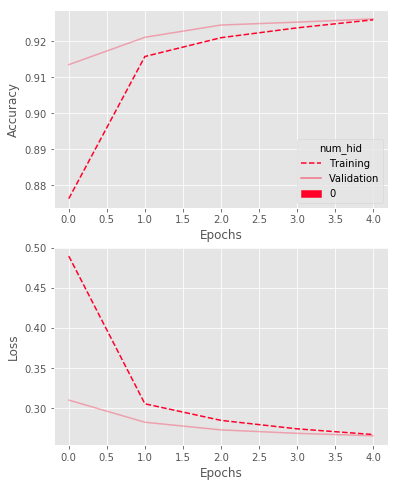

In [231]:
history_readout_in.plot_acc_loss("", "", "val_")

# Error Data <a class="anchor" id="error-data"></a>

In [ ]:
ro_in = load_model('data/incite/models_log/mnist_new/readout_in/readout_num_hid=0')
%time ls_in, acs_in = h.get_ro(ro_in, x_test_vec, y_test_hot, max_pixels=784, num_rounds=1)

In [ ]:
with open('data/incite/models_log/mnist_new/robustness/ls_in.pkl', 'wb') as f:
    pkl.dump(ls_in, f)
with open('data/incite/models_log/mnist_new/robustness/acs_in.pkl', 'wb') as f:
    pkl.dump(acs_in, f)

In [12]:
# !!! PATHS
keys_vec = ['simple', 'sparse', 'deep_1', 'deep_2', 'deep_3', 'deep_4']
keys_conv = ['conv', 'denois', 'denois_o']

encoders = {'simple': 'data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid=0', \
            'sparse': 'data/incite/models_log/mnist_new/sparsity_search/batch_size=32/encoder_1e-05', \
            'deep_1': 'data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid=1', \
            'deep_2': 'data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid=2', \
            'deep_3': 'data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid=3', \
            'deep_4': 'data/incite/models_log/mnist_new/deep_ae/deep_encoder_num_hid=4', \
            'conv': 'data/incite/models_log/mnist_new/conv_ae/conv_encoder', \
            'denois': 'data/incite/models_log/mnist_new/denois_ae/denois_encoder', \
            'denois_o': 'data/incite/models_log/mnist_new/denois_ae/denois_encoder'}

ro_frozenweights = {'simple': 'data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/readout_num_hid=0', \
               'sparse': 'data/incite/models_log/mnist_new/readout_ae_1e-05/frozenweights/readout_num_hid=0', \
               'deep_1': 'data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/readout_num_hid=1', \
               'deep_2': 'data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/readout_num_hid=2', \
               'deep_3': 'data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/readout_num_hid=3', \
               'deep_4': 'data/incite/models_log/mnist_new/readout_deep_ae/frozenweights/readout_num_hid=4', \
               'conv': 'data/incite/models_log/mnist_new/readout_conv_ae/frozenweights/readout', \
               'denois': 'data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/readout', \
               'denois_o': 'data/incite/models_log/mnist_new/readout_denois_ae/frozenweights/readout_orig'}

ro_finetuning = {'simple': 'data/incite/models_log/mnist_new/readout_deep_ae/finetuning/readout_num_hid=0', \
             'sparse': 'data/incite/models_log/mnist_new/readout_ae_1e-05/finetuning/readout_num_hid=0', \
             'deep_1': 'data/incite/models_log/mnist_new/readout_deep_ae/finetuning/readout_num_hid=1', \
             'deep_2': 'data/incite/models_log/mnist_new/readout_deep_ae/finetuning/readout_num_hid=2', \
             'deep_3': 'data/incite/models_log/mnist_new/readout_deep_ae/finetuning/readout_num_hid=3', \
             'deep_4': 'data/incite/models_log/mnist_new/readout_deep_ae/finetuning/readout_num_hid=4', \
             'conv': 'data/incite/models_log/mnist_new/readout_conv_ae/finetuning/readout', \
             'denois': 'data/incite/models_log/mnist_new/readout_denois_ae/finetuning/readout', \
             'denois_o': 'data/incite/models_log/mnist_new/readout_denois_ae/finetuning/readout_orig'}

In [ ]:
for key in keys_vec:
    print(key)
    ro_repr = load_model(ro_finetuning[key])
    print('loaded')
    %time ls_repr, acs_repr = h.get_ro(ro_repr, x_test_vec, y_test_hot, max_pixels=784, num_rounds=1, step=10)
    with open('data/incite/models_log/mnist_new/robustness/finetuning/ls_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(ls_repr, f)
    with open('data/incite/models_log/mnist_new/robustness/finetuning/acs_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(acs_repr, f)

In [ ]:
for key in keys_vec:
    print(key)
    ro_repr = load_model(ro_frozenweights[key])
    encoder = load_model(encoders[key])
    print('loaded')
    %time ls_repr, acs_repr = h.get_ro_repr(ro_repr, encoder, x_test_vec, y_test_hot, \
                                            max_pixels=784, num_rounds=1, step=10)
    with open('data/incite/models_log/mnist_new/robustness/frozenweights/ls_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(ls_repr, f)
    with open('data/incite/models_log/mnist_new/robustness/frozenweights/acs_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(acs_repr, f)

In [ ]:
for key in keys_conv:
    print(key)
    ro_repr = load_model(ro_finetuning[key])
    print('loaded')
    %time ls_repr, acs_repr = h.get_ro(ro_repr, x_test_conv, y_test_hot, max_pixels=784, \
                                       num_rounds=1, step=10, conv=True)
    with open('data/incite/models_log/mnist_new/robustness/finetuning/ls_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(ls_repr, f)
    with open('data/incite/models_log/mnist_new/robustness/finetuning/acs_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(acs_repr, f)

In [ ]:
for key in keys_conv:
    print(key)
    ro_repr = load_model(ro_frozenweights[key])
    encoder = load_model(encoders[key])
    print('loaded')
    %time ls_repr, acs_repr = h.get_ro_repr(ro_repr, encoder, x_test_vec, y_test_hot, \
                                            max_pixels=784, num_rounds=1, step=10, conv=True)
    with open('data/incite/models_log/mnist_new/robustness/frozenweights/ls_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(ls_repr, f)
    with open('data/incite/models_log/mnist_new/robustness/frozenweights/acs_repr_{}.pkl'.format(key), 'wb') as f:
        pkl.dump(acs_repr, f)

In [321]:
plt_titles = {'simple': 'MNIST\n784-10- AE + 10-10 RO\n5 epochs, batch_size = 32', \
              'sparse': 'MNIST\n784-1000- Sparse AE + 1000-10 RO\n5 epochs, batch_size = 32', \
              'deep_1': 'MNIST\n784-397-10- AE + 10-10 RO\n5 epochs, batch_size = 32', \
              'deep_2': 'MNIST\n784-526-268-10- AE + 10-10 RO\n5 epochs, batch_size = 32', \
              'deep_3': 'MNIST\n784-590-397-203-10- AE + 10-10 RO\n5 epochs, batch_size = 32', \
              'deep_4': 'MNIST\n784-629-474-319-164-10- AE + 10-10 RO\n5 epochs, batch_size = 32', \
              'conv': 'MNIST\nConv AE + 4x4x8-10 RO\n5 epochs, batch_size = 32', \
              'denois': 'MNIST\nDenois AE + 7x7x32-10 Noisy RO\n5 epochs, batch_size = 32', \
              'denois_o': 'MNIST\nDenois AE + 7x7x32-10 Original RO\n5 epochs, batch_size = 32'}

fig_name = 'data/incite/models_log/mnist_new/pics/{}_{}.pdf'

In [355]:
def plot_readout(mode={'loss', 'acc'}):
    d = {'loss': 'Loss', 'acc': 'Accuracy'}
    for key in keys_vec + keys_conv:
        plt.clf()
        if mode == 'loss':
            with open('data/incite/models_log/mnist_new/robustness/ls_in.pkl'.format(key), 'rb') as f:
                plot_in = pkl.load(f)
            with open('data/incite/models_log/mnist_new/robustness/finetuning/ls_repr_{}.pkl'.format(key), 'rb') as f:
                plot_finetuning = pkl.load(f)
            with open('data/incite/models_log/mnist_new/robustness/frozenweights/ls_repr_{}.pkl'.format(key), 'rb') as f:
                plot_frozenweights = pkl.load(f)
        else:
            with open('data/incite/models_log/mnist_new/robustness/acs_in.pkl'.format(key), 'rb') as f:
                plot_in = pkl.load(f)
            with open('data/incite/models_log/mnist_new/robustness/finetuning/acs_repr_{}.pkl'.format(key), 'rb') as f:
                plot_finetuning = pkl.load(f)
            with open('data/incite/models_log/mnist_new/robustness/frozenweights/acs_repr_{}.pkl'.format(key), 'rb') as f:
                plot_frozenweights = pkl.load(f)
        with plt.style.context('ggplot'):
            plt.figure(figsize=(6, 4))
            plt.subplots_adjust(top=0.8)
            plt.plot(np.arange(0, 784, 10), plot_in[::10], label='input', linestyle=':')
            plt.plot(np.arange(0, 784, 10), plot_frozenweights, label='frozen weights', alpha=0.7)
            plt.plot(np.arange(0, 784, 10), plot_finetuning, label='fine-tuning', alpha=0.7)
            plt.legend()
            plt.title(plt_titles[key])
            plt.xlabel('Missing Pixels')
            plt.ylabel(d[mode])
            if mode == 'acc':
                plt.ylim(-0.05, 1.05)
                plt.xlim(-25, 800)
            if mode == 'loss':
                if key.startswith('denois'):
                    plt.ylim(-0.5, 9)
                else:
                    plt.ylim(-0.5, 6)
                plt.xlim(-25, 800)
            plt.savefig(fig_name.format(mode, key), dpi=300)

In [350]:
def plot_readout_2(mode={'loss', 'acc'}, mode2={'finetuning', 'frozenweights'}):
    plt.clf()
    with plt.style.context('ggplot'):
        plt.figure(figsize=(6, 4))
        plt.subplots_adjust(top=0.9)
        d = {'loss': 'Loss', 'acc': 'Accuracy'}
        d_sh = {'loss': 'ls', 'acc': 'acs'}
        d_mode = {'finetuning': 'Fine-tuning', 'frozenweights': 'Frozen Weights'}
        with open('data/incite/models_log/mnist_new/robustness/{}_in.pkl'.format(d_sh[mode]), 'rb') as f:
            plot_in = pkl.load(f)
        plt.plot(np.arange(0, 784, 10), plot_in[::10], label='input', linestyle=':')
        colors=(cm.get_cmap('viridis')(i) for i in np.linspace(0, 1, 9))
        for key in keys_vec + keys_conv:
            color = next(colors)
            with open('data/incite/models_log/mnist_new/robustness/{}/{}_repr_{}.pkl'.format(mode2, d_sh[mode], key), 'rb') as f:
                plot = pkl.load(f)
            if key.startswith('denois') or key.startswith('conv'):
                plt.plot(np.arange(0, 784, 10), plot, label=key, linestyle='--', alpha=0.7, c=color)
            elif key.startswith('deep'):
                plt.plot(np.arange(0, 784, 10), plot, label=key, alpha=0.7, c=color)
            else:
                plt.plot(np.arange(0, 784, 10), plot, label=key, linestyle='-.', alpha=0.7, c=color)
        plt.legend()
        plt.title(d_mode[mode2])
        plt.xlabel('Missing Pixels')
        plt.ylabel(d[mode])
        plt.savefig(fig_name.format(mode2, mode), dpi=300)

In [ ]:
plot_readout('loss')
plot_readout('acc')

In [ ]:
plot_readout_2('loss', 'finetuning')
plot_readout_2('acc', 'finetuning')

In [ ]:
plot_readout_2('loss', 'frozenweights')
plot_readout_2('acc', 'frozenweights')